# inter-run comparisons of N contained in phytoplankton
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
import h5py
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plist=['Sentry Shoal','S3']

In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

t0=dt.datetime(2015,2,6)
fdur=10 # length of each results file in days

In [4]:
saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/comparePhytoN/'
baseloc='/data/eolson/MEOPAR/SS36runs/CedarRuns/'
#dirname1='HCS15'
dirname1='hindcast2015'
dirnames=(dirname1,'hindcast2016','hindcast2017')
#dirnames=('spring2015_NewSink','spring2015_slowPP','spring2015_KhT','spring2015_diatHS')
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
ff=dict()
for idir in dirnames:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')

/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_S3.nc


In [5]:
times=dict()
for idir in dirnames:
    f=ff[idir]['S3']
    torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print(torig)
    times[idir]=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00
1900-01-01 00:00:00
1900-01-01 00:00:00


In [6]:
tmins=list()
tmaxs=list()
for idir in dirnames:
    tmins.append(times[idir][0])
    tmaxs.append(times[idir][-1])
xl=(np.min(np.array(tmins)),np.max(np.array(tmaxs)))
xl=(dt.datetime(2015,3,1),dt.datetime(2015,3,20))

In [7]:
# load Sentry Shoal Nitrate
filepathN = '/ocean/eolson/MEOPAR/obs/Hakai/SentryShoal/Full_SUNA_Processed.mat'

arrays = {}
fSSN = h5py.File(filepathN)
for k, v in fSSN.items():
    arrays[k] = np.array(v)
ssdates = arrays['Full_SUNA_Processed'][0,:]
sstimes = arrays['Full_SUNA_Processed'][1,:]
sstemps = arrays['Full_SUNA_Processed'][2,:]
sssals = arrays['Full_SUNA_Processed'][3,:]
ssnitrate = arrays['Full_SUNA_Processed'][5,:]
ssdatenumber = arrays['Full_SUNA_Processed'][-1, :]
ssbase = dt.datetime(2000, 1, 1)
py_times = np.array([ssbase for i in range(63721)])
for n in range(63721):
    py_times[n] = ((dt.datetime.fromordinal(int(ssdatenumber[n])))
                       + dt.timedelta(days=ssdatenumber[n]%1)
                       - dt.timedelta(days = 366))
ssn = np.ma.masked_invalid(ssnitrate)


In [8]:
iend={'S3':3,'Sentry Shoal':2}

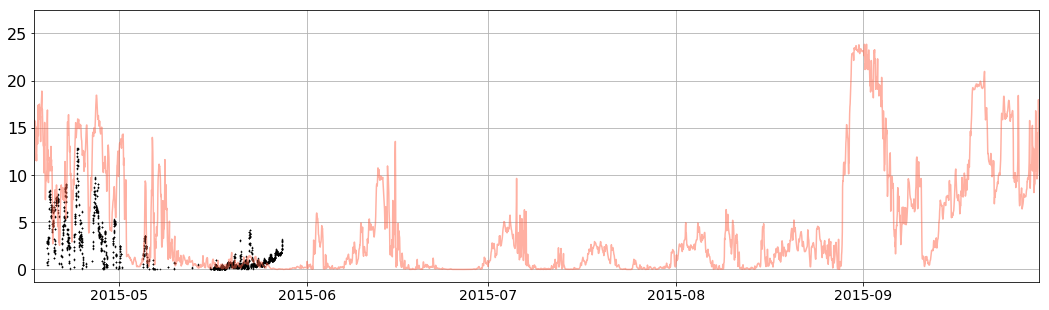

In [16]:
#2015: not enough data 
iiiSS=(py_times>=dt.datetime(2015,3,1))&(py_times<=dt.datetime(2015,6,1))
fig,ax=plt.subplots(1,1,figsize=(18,5))
iax=ax
iax.plot(py_times[iiiSS],ssn[iiiSS],'.',color='k',markersize=1)
fc=ff['hindcast2015']['Sentry Shoal']
rr='Sentry Shoal'
pN,=iax.plot(times['hindcast2015'],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',color='tomato',alpha=.5)
iax.set_xlim(dt.datetime(2015,4,17),dt.datetime(2015,9,30))
iax.grid('on')

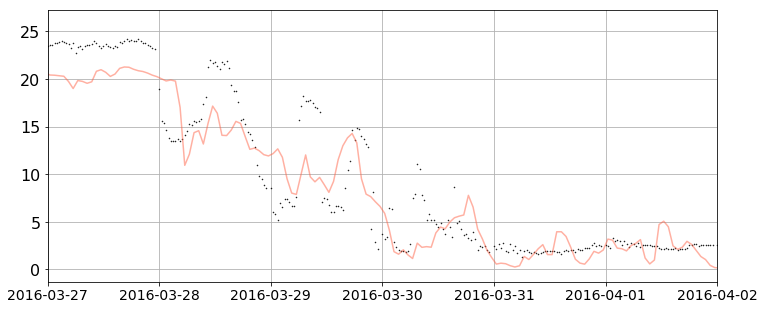

In [10]:
#2016: 
iiiSS=(py_times>=dt.datetime(2016,3,1))&(py_times<=dt.datetime(2016,6,1))
fig,ax=plt.subplots(1,1,figsize=(12,5))
iax=ax
iax.plot(py_times[iiiSS],ssn[iiiSS],'.',color='k',markersize=1)
fc=ff['hindcast2016']['Sentry Shoal']
rr='Sentry Shoal'
pN,=iax.plot(times['hindcast2016'],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',color='tomato',alpha=.5)
iax.set_xlim(dt.datetime(2016,3,27),dt.datetime(2016,4,2))
iax.grid('on')

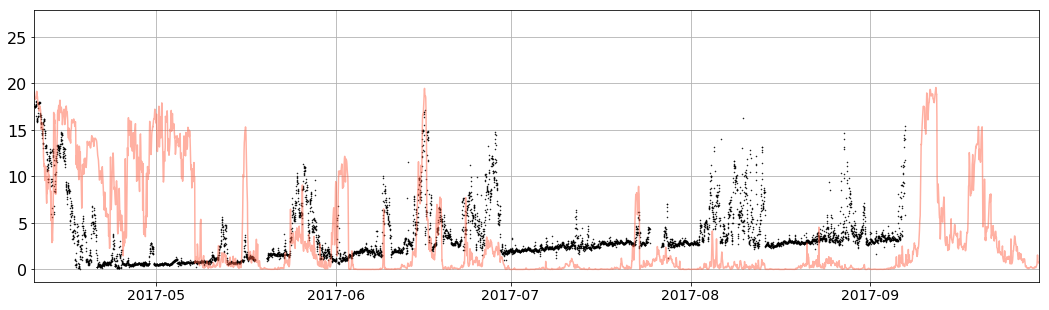

In [11]:
#2017: 
iiiSS=(py_times>=dt.datetime(2017,3,1))&(py_times<=dt.datetime(2017,10,1))
fig,ax=plt.subplots(1,1,figsize=(18,5))
iax=ax
iax.plot(py_times[iiiSS],ssn[iiiSS],'.',color='k',markersize=1)
fc=ff['hindcast2017']['Sentry Shoal']
rr='Sentry Shoal'
pN,=iax.plot(times['hindcast2017'],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',color='tomato',alpha=.5)
iax.set_xlim(dt.datetime(2017,4,10),dt.datetime(2017,9,30))
iax.grid('on')

## now load wind

In [13]:
f=nc.Dataset('/results/forcing/atmospheric/GEM2.5/operational/ops_y2015m06d01.nc')

In [15]:
f.variables['u_wind']

<class 'netCDF4._netCDF4.Variable'>
float32 u_wind(time_counter, y, x)
    _FillValue: 9.999e+20
    short_name: UGRD_10maboveground
    long_name: U-Component of Wind
    level: 10 m above ground
    units: m/s
    coordinates: longitude latitude
unlimited dimensions: time_counter
current shape = (24, 266, 256)
filling on

In [12]:
def list_wind_files(
    to, tf,
    wind_dir='/results/forcing/atmospheric/GEM2.5/operational/'
):
    """List operational wind files in date range [to, tf]

    :arg to: beginning of date range
    :type to: datetime object

    :arg tf: end of date range
    :type tf: datetime object

    :arg wind_dir: directory were wind files are stored
    :type wind_dir: str

    :returns: filesOP, a list of files in date range
    """
    sstr = to.strftime('ops_y%Ym%md%d.nc')
    estr = tf.strftime('ops_y%Ym%md%d.nc')
    files = glob.glob(os.path.join(wind_dir, 'ops_*.nc'))
    filesOP = []
    for filename in files:
        if os.path.basename(filename) >= sstr:
            if os.path.basename(filename) <= estr:
                if not filename.endswith('orig.nc'):
                    filesOP.append(filename)
        filesOP.sort(key=os.path.basename)
    filesOP.sort(key=os.path.basename)
    return filesOP

In [20]:
places.PLACES['Sentry Shoal']

{'EC buoy number': 46131,
 'GEM2.5 grid ji': (183, 107),
 'NEMO grid ji': (707, 145),
 'lon lat': (-125.0, 49.92)}

In [30]:
files=list_wind_files(dt.datetime(2015,5,15),dt.datetime(2015,8,15))
j=183
i=107

In [48]:
wind = []
direc = []
uw = []
vw = []
pr=[]
t = []
wind_d = []
direc_d = []
uw_d = []
vw_d = []
pr_d=[]
t_d = []
for f in files:
    G = nc.Dataset(f)
    u = G.variables['u_wind'][0:24, j, i]
    v = G.variables['v_wind'][0:24, j, i]
    uw.append(u)
    uw_d.append(np.mean(u))
    vw.append(v)
    vw_d.append(np.mean(v))
    pr.append(G.variables['atmpres'][0:24, j, i])
    pr_d.append(np.mean(G.variables['atmpres'][0:24, j, i]))
    speed = np.sqrt(u**2 + v**2)
    wind.append(speed)
    wind_d.append(np.mean(speed))
    d = np.arctan2(v, u)
    d = np.rad2deg(d + (d < 0)*2*np.pi)
    direc.append(d)
    ts = G.variables['time_counter']
    torig = dt.datetime(1970, 1, 1)
    # there is no time_origin attribute in OP files, so I hard coded torig
    for ind in np.arange(24):
        t.append(torig + dt.timedelta(seconds=ts[ind]))
    t_d.append(torig + dt.timedelta(seconds=np.mean(ts)))
numdays = len(files)
wind = np.array(wind).reshape(numdays*24,)
direc = np.array(direc, 'double').reshape(numdays*24,)
pr = np.array(pr).reshape(numdays*24,)
uw = np.array(uw).reshape(numdays*24,)
vw = np.array(vw).reshape(numdays*24,)
t = np.array(t).reshape(numdays*24,)
wind_d = np.array(wind_d).reshape(numdays,)
pr_d = np.array(pr_d).reshape(numdays,)
uw_d = np.array(uw_d).reshape(numdays,)
vw_d = np.array(vw_d).reshape(numdays,)
t_d = np.array(t_d).reshape(numdays,)

In [33]:
us,vs=viz_tools.rotate_vel(uw,vw,origin='map')
us_d,vs_d=viz_tools.rotate_vel(uw_d,vw_d,origin='map')

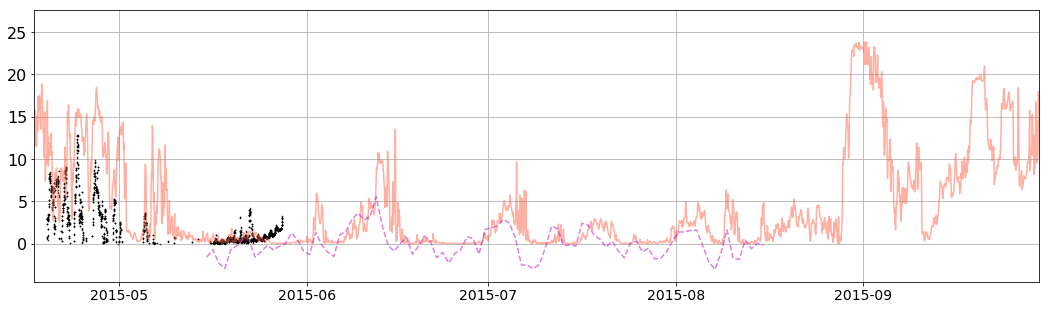

In [135]:
#2015: not enough data 
iiiSS=(py_times>=dt.datetime(2015,3,1))&(py_times<=dt.datetime(2015,6,1))
fig,ax=plt.subplots(1,1,figsize=(18,5))
iax=ax
iax.plot(py_times[iiiSS],ssn[iiiSS],'.',color='k',markersize=1)
fc=ff['hindcast2015']['Sentry Shoal']
rr='Sentry Shoal'
pN,=iax.plot(times['hindcast2015'],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',color='tomato',alpha=.5)
iax.set_xlim(dt.datetime(2015,4,17),dt.datetime(2015,9,30))
iax.grid('on')
#iax.plot(t,vs,'c--',alpha=.2)
#iax.plot(t,vw,'b--',alpha=.2)
#iax.plot(t,-wind,'m--',alpha=.2)
iax.plot(t_d,wind_d-np.mean(wind_d),'m--',alpha=.5)
#iax.plot(t,(pr-np.mean(pr))*.01,'r--',alpha=.2)

In [77]:
w=np.where((times['hindcast2015']>=dt.datetime(2015,5,15,0,30))&(times['hindcast2015']<=dt.datetime(2015,8,15,0,30)))
i0=w[0][0]
i1=w[0][-1]
xmodN=np.sum(fc.variables['nitrate'][i0:i1,:iend[rr],0,0]*fc.variables['e3t'][i0:i1,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][i0:i1,:iend[rr],0,0],1)

In [78]:
len(xmodN)

2208

In [79]:
w2=np.where((t>=dt.datetime(2015,5,15))&(t<=dt.datetime(2015,8,15)))

In [80]:
i20=w2[0][0]
i21=w2[0][-1]
yopsW=wind[i20:i21]

In [81]:
len(yopsW)

2208

In [122]:
2208/24

92.0

In [86]:
np.correlate(xmodN,yopsW)

array([16155.869], dtype=float32)

In [87]:
output = np.correlate(xmodN,yopsW,mode='full')

In [88]:
output

array([4.818766 , 6.3173084, 6.7392673, ..., 0.8522819, 0.4445509,
       0.162    ], dtype=float32)

(12000, 18000)

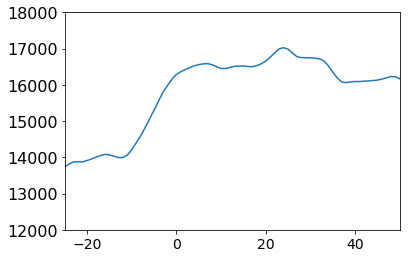

In [104]:
plt.plot(np.arange(-len(yopsW),len(yopsW)-1),output)
plt.xlim(-25,50)
plt.ylim(12000,18000)

In [108]:
np.corrcoef(xmodN,yopsW)

array([[1.       , 0.3384518],
       [0.3384518, 1.       ]])

In [120]:
for ii in range(1,48):
    ij=-1*ii
    print(ii,np.corrcoef(xmodN[ii:],yopsW[:ij])[0,1])

1 0.3519715718210282
2 0.35921629983235026
3 0.36540841161848137
4 0.3703033555197601
5 0.3749182078897491
6 0.3780188617346953
7 0.38005655389252396
8 0.38068384640667163
9 0.37799017315974637
10 0.373227397931706
11 0.36925743498573993
12 0.3698498555557553
13 0.3733039490030786
14 0.37710674457731935
15 0.3781258948905182
16 0.3794106575705427
17 0.3784691716239336
18 0.3783759546888786
19 0.381791163290153
20 0.3873473779329006
21 0.39536000964111084
22 0.40547690096908473
23 0.4169688526211171
24 0.42762626735339393
25 0.4308157708991547
26 0.42681953541128254
27 0.41622767166087205
28 0.40638965317248077
29 0.40368052222301304
30 0.40331795334737675
31 0.40287237707565127
32 0.4019468208807122
33 0.40031822918468946
34 0.39553743470807623
35 0.38309622926201053
36 0.36621048243384763
37 0.35104071276412685
38 0.3402304496654113
39 0.3387525141667192
40 0.341182775208093
41 0.3427573990612256
42 0.3430437205505874
43 0.34474539331700105
44 0.3460824885414866
45 0.34795473288560336

In [121]:
for ii in range(1,48):
    ij=-1*ii
    print(ii,np.corrcoef(yopsW[ii:],xmodN[:ij])[0,1])

1 0.32116070266635577
2 0.3035851669492392
3 0.27988947778319595
4 0.2554976268878258
5 0.23233403952506956
6 0.20918209864574283
7 0.18780475565903457
8 0.1695464666105358
9 0.15184838016217336
10 0.137276120045104
11 0.13098133382473542
12 0.1314111580793718
13 0.13497150792928247
14 0.1389626435711851
15 0.14053975310568528
16 0.13747293442778966
17 0.1329322630111187
18 0.12800991751386714
19 0.12370216127897095
20 0.11981037345441123
21 0.11942193844726587
22 0.11891624510974783
23 0.11323385893818308
24 0.10439850183497403
25 0.09021595167650251
26 0.07634910822454118
27 0.060305412056837274
28 0.03965941320857153
29 0.0182735576751164
30 -0.002222287028844571
31 -0.020049550216580062
32 -0.03317836411301462
33 -0.04600735322215764
34 -0.05366203089575473
35 -0.053251093926021335
36 -0.04722014160062965
37 -0.041612580246944524
38 -0.03744426515655044
39 -0.030717628121171243
40 -0.023621116912312543
41 -0.020738319907934573
42 -0.020365971612184817
43 -0.020674716719733963
44 -0

In [124]:
import scipy.stats as ss

In [128]:
tnum=[(ii-dt.datetime(1900,1,1)).days for ii in times['hindcast2015'][i0:i1]]
val,edges,inds=ss.binned_statistic(tnum, xmodN, statistic='mean', 
                                    bins=(dt.datetime(2015,8,15)-dt.datetime(2015,5,15)).days)

In [129]:
len(val)

92

In [130]:
len(wind_d)

93

In [133]:
np.corrcoef(val,wind_d[:-1])

array([[1.        , 0.51340397],
       [0.51340397, 1.        ]])

In [134]:
for ii in range(1,5):
    ij=-1*ii-1
    print(ii,np.corrcoef(val[ii:],wind_d[:ij])[0,1])

1 0.6598134265959918
2 0.5886811645823719
3 0.5081635841444229
4 0.40729332486966996


In [137]:
for ii in range(1,5):
    ij=-1*ii
    print(ii,np.corrcoef(wind_d[ii:],wind_d[:ij])[0,1])

1 0.6301855685077155
2 0.265928229013062
3 0.1004283011937818
4 -0.018115039333346915


In [139]:
for ii in range(1,15):
    ij=-1*ii
    print(ii,np.corrcoef(val[ii:],val[:ij])[0,1])

1 0.8042711824694706
2 0.49613203605542533
3 0.2251995884847418
4 0.034349195690469764
5 -0.08684981168755361
6 -0.17763162831961085
7 -0.22916716284936833
8 -0.24571114199648325
9 -0.2252232875730509
10 -0.1850933373282091
11 -0.1666084425722944
12 -0.1836350115239266
13 -0.1793931948195116
14 -0.16986970258979298
